In [18]:
import numpy as np
import keras

from matplotlib import pyplot as plt

In [19]:
def get_squares_dataset(n_samples=1000, noise_level=0.1):
    num_samples_per_square = n_samples // 4
    centers = [[0, 3.75], [0, 0], [3.5, 0], [3.5, 3.75]]
    variance = [[noise_level, 0], [0, noise_level]]
    X = np.vstack([
        np.random.multivariate_normal(center, variance, num_samples_per_square) for center in centers
    ])
    y = np.hstack([
        np.full(num_samples_per_square, i % 2) for i in range(4)
    ])
    return X, y

X, y = get_squares_dataset(n_samples=2000, noise_level=0.2)

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_scaled = scaler.fit_transform(X)

In [20]:
def visualize(X, y, title=""):
    plt.figure(figsize=(8, 8))

    jitter = 0.02
    X_jittered = X + np.random.normal(0, jitter, X.shape)

    plt.scatter(X_jittered[y == 0, 0], X_jittered[y == 0, 1], color='red', alpha=0.5, marker='x', label='Inner Circle')
    plt.scatter(X_jittered[y == 1, 0], X_jittered[y == 1, 1], color='blue', alpha=0.5, marker='^', label='Outer Loop')

    plt.title(title)
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.legend()
    plt.grid(True)

    plt.show()

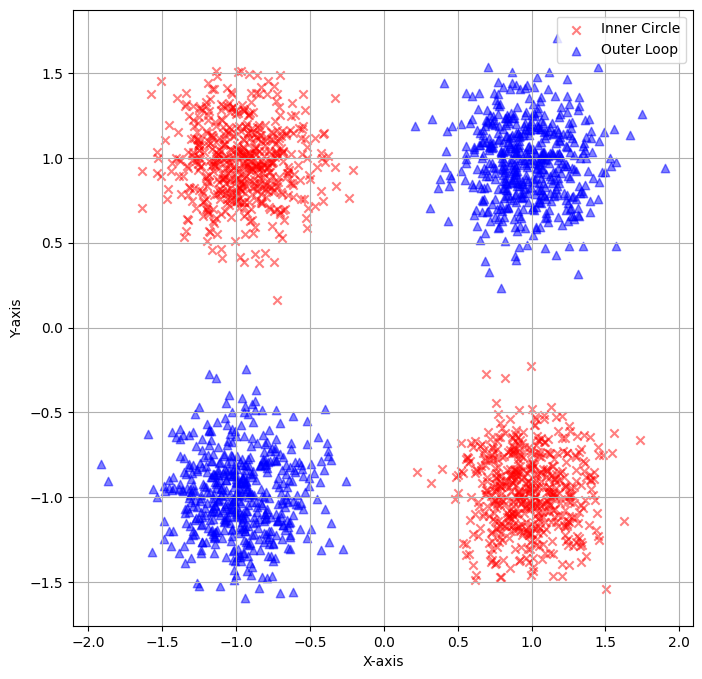

In [21]:
visualize(X_scaled, y)

In [22]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [ ]:
from keras.layers import Dense
from keras.optimizers import Adam
from keras.losses import BinaryCrossentropy
from keras.regularizers import L2
from keras import Sequential


def build_model(activation="leaky_relu", layers=5, weight_decay=2e-3):
    model = Sequential()

    for _ in range(layers - 1):
        layer = Dense(2, activation=activation, kernel_regularizer=L2(weight_decay))
        model.add(layer)

    model.add(Dense(1, activation='sigmoid', kernel_regularizer=L2(weight_decay)))

    return model

model = build_model(
    layers=5, 
    weight_decay=2e-3,  # we want small weight for nice visualization
    activation='tanh'
)

model.compile(
    optimizer=Adam(learning_rate=0.003),
    loss=BinaryCrossentropy(),
    metrics=['accuracy']
)

In [ ]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_accuracy', patience=20, mode='max',
                               baseline=0.9, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=100, batch_size=16,
                    validation_data=(X_test, y_test), callbacks=[early_stopping])

In [28]:
model.evaluate(X_test, y_test)

13/13 [==============================] - 0s 474us/step - loss: 0.0972 - accuracy: 1.0000


[0.09724433720111847, 1.0]

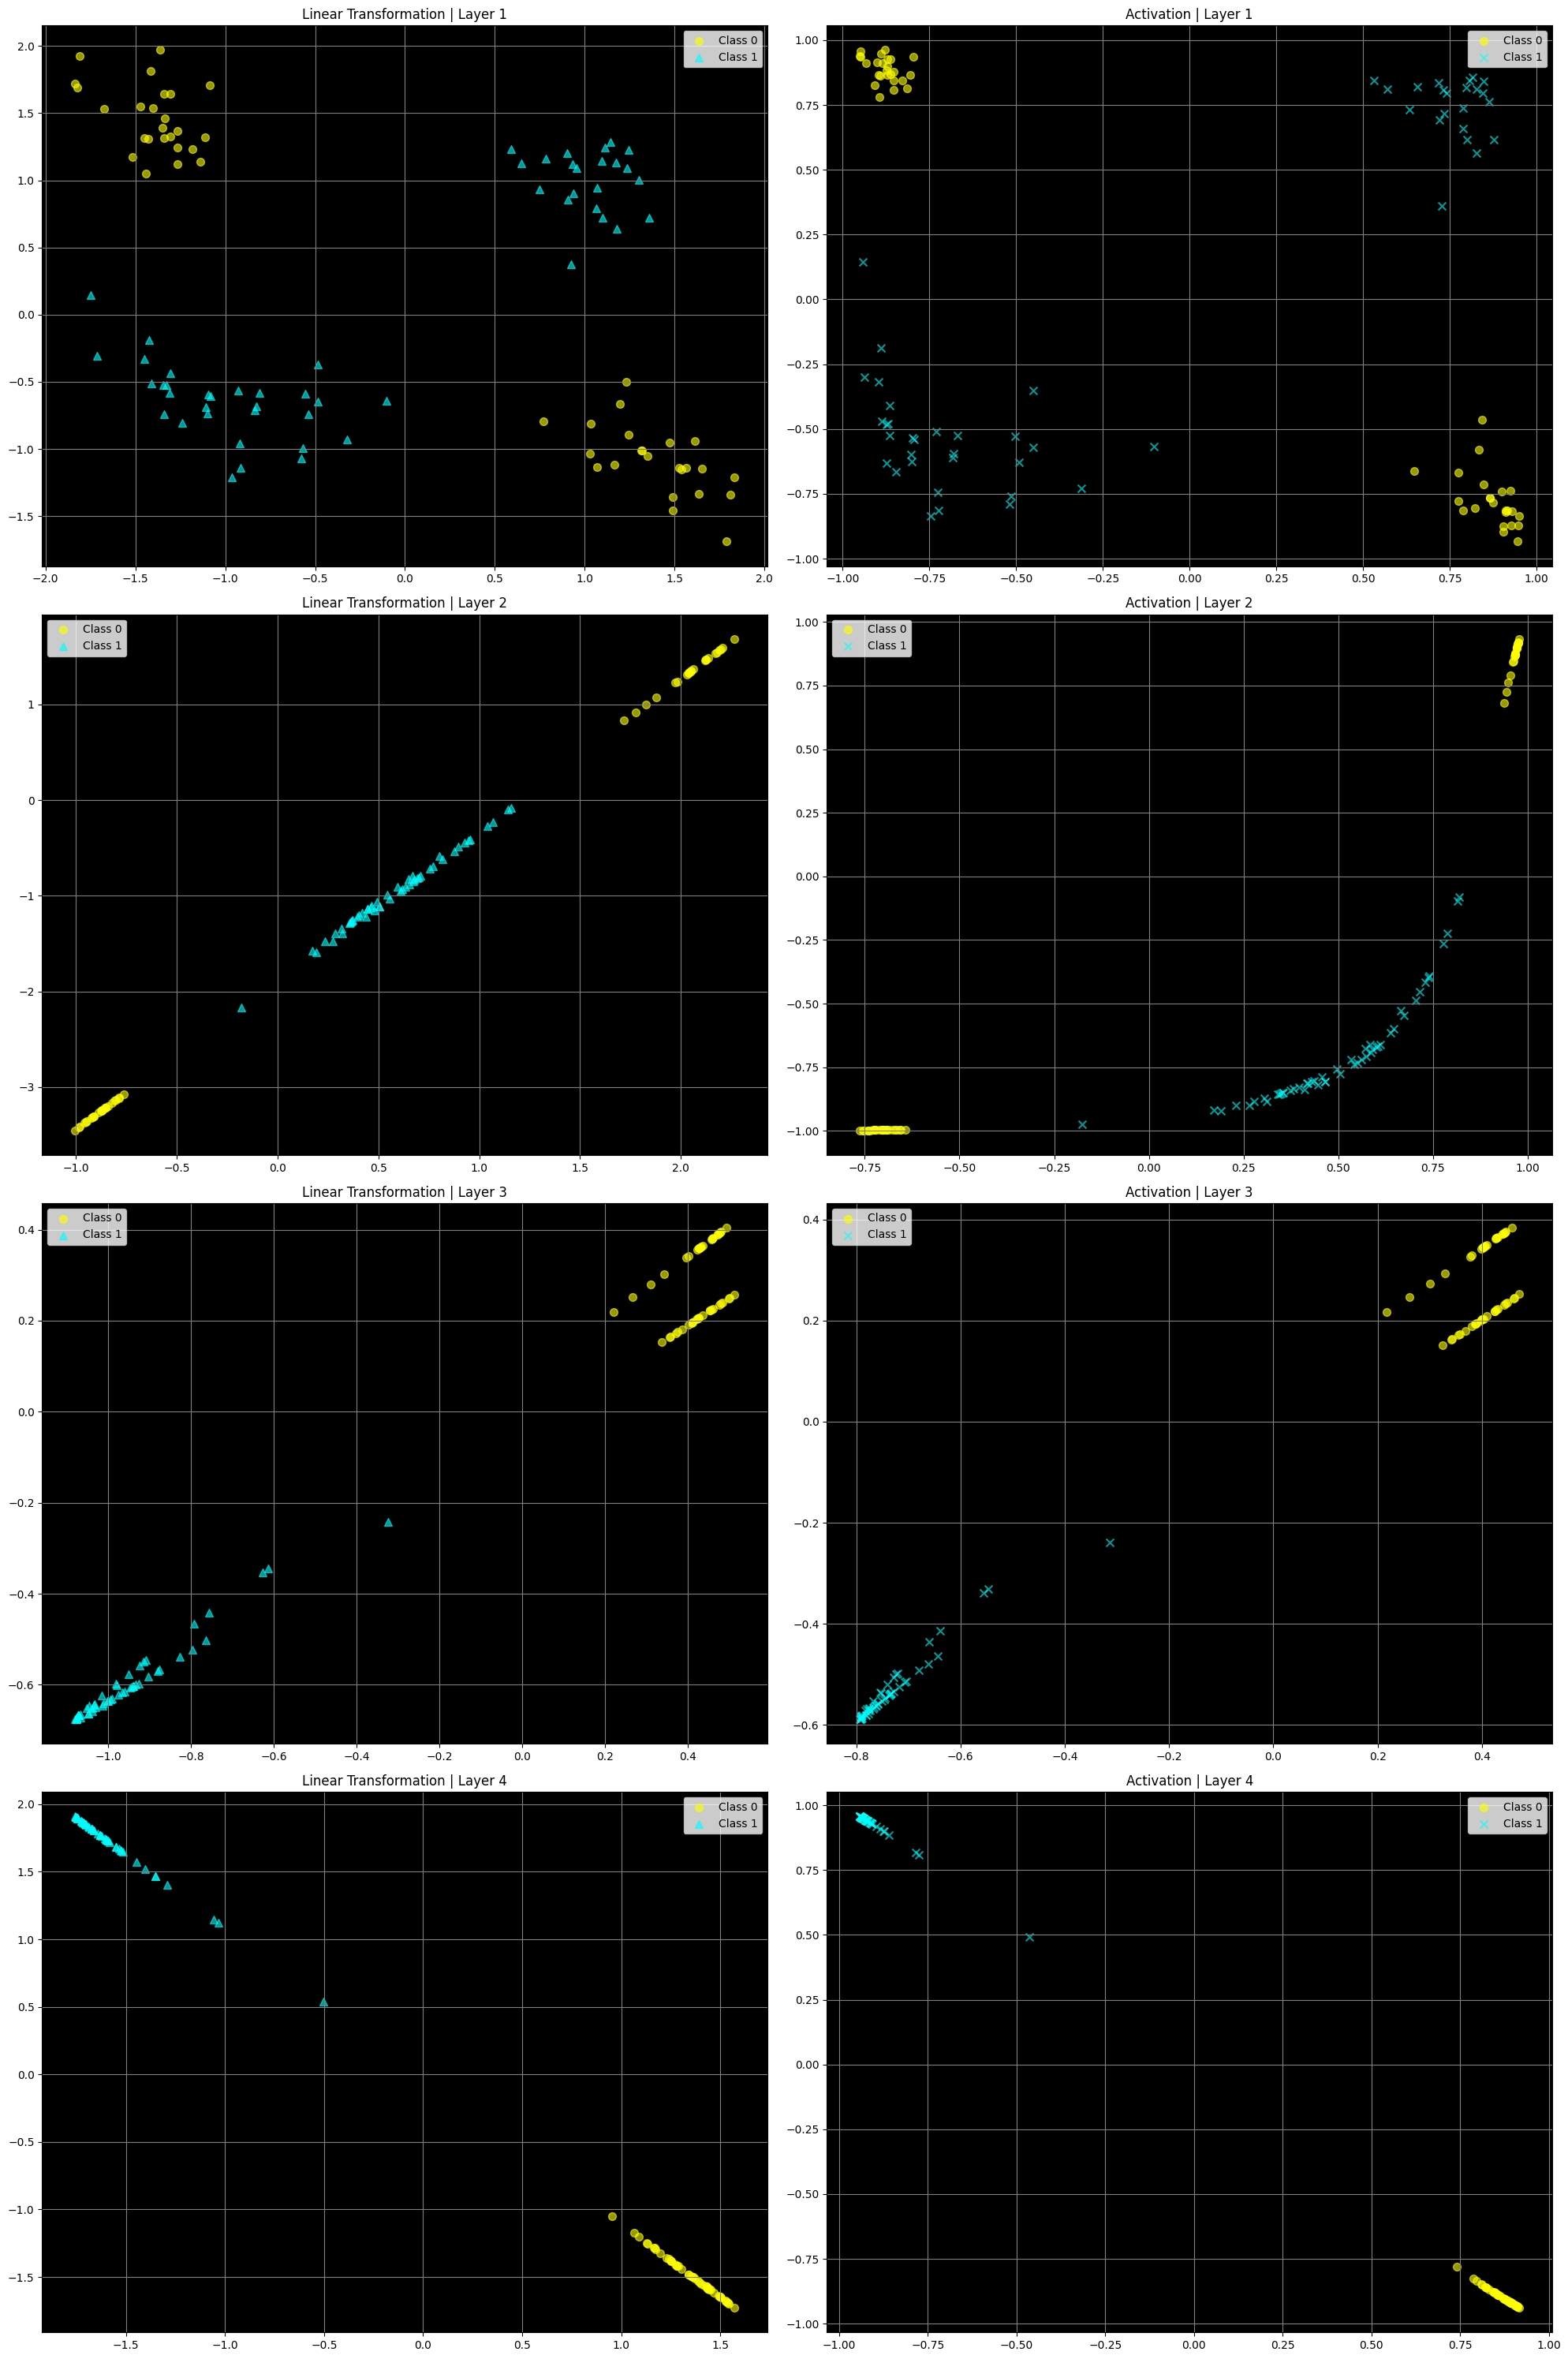

In [29]:
import matplotlib.pyplot as plt
import numpy as np
from keras.models import Model

def visualize_grid(X, y, model, rows, cols, figsize=(15, 20)):
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    transparency = 0.6
    marker_size = 50

    for idx, layer in enumerate(model.layers[:-1]):
        if hasattr(layer, 'get_weights') and len(layer.get_weights()) > 0:
            w, b = layer.get_weights()
            z = np.dot(X, w) + b

            # Plot linear transformation
            ax = axes[idx, 0]
            ax.scatter(z[y == 0, 0], z[y == 0, 1], color='yellow', alpha=transparency, marker='o', s=marker_size, label='Class 0')
            ax.scatter(z[y == 1, 0], z[y == 1, 1], color='cyan', alpha=transparency, marker='^', s=marker_size, label='Class 1')
            ax.set_title(f"Linear Transformation | Layer {idx+1}")
            ax.legend()
            ax.grid(True, color='gray')
            ax.set_facecolor('black')

            # Apply activation function
            activation_function = keras.activations.get(layer.activation)
            X_transformed = activation_function(z).numpy()

            # Plot activation transformation
            ax = axes[idx, 1]
            ax.scatter(X_transformed[y == 0, 0], X_transformed[y == 0, 1], color='yellow', alpha=transparency, marker='o', s=marker_size, label='Class 0')
            ax.scatter(X_transformed[y == 1, 0], X_transformed[y == 1, 1], color='cyan', alpha=transparency, marker='x', s=marker_size, label='Class 1')
            ax.set_title(f"Activation | Layer {idx+1}")
            ax.legend()
            ax.grid(True, color='gray')
            ax.set_facecolor('black')

            # Prepare data for the next layer
            X = X_transformed

    plt.tight_layout()
    plt.show()

x_transformed = X_test[:100].copy()
y_new = y_test[:100].copy()
number_of_layers = len([l for l in model.layers if hasattr(l, 'get_weights') and len(l.get_weights()) > 0])
visualize_grid(x_transformed, y_new, model, number_of_layers-1, 2, figsize=(20, 30))

In [30]:
model.save("model.keras")